<a href="https://colab.research.google.com/github/OneRealUni/Stock-Value-Prediction/blob/master/Copy_of_Stock_time_series_deep_AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Value Prediction Exercise in SageMaker using DeepAR
This small project works with data extracted from Yahoo Finance



![alt text](https://drive.google.com/uc?export=view&id=1CscQfP79cskW5daDcfz8jEvxg9t40H1n)


In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Loading the CSV file

In [3]:
# dataset: https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014
# data = pd.read_csv('/content/drive/My Drive/AICamp/DL/TimeSeries/Data/GOOG.csv', sep=";", index_col=0, parse_dates=True, decimal=',')
# num_timeseries = data.shape[1]
df = pd.read_csv('/content/drive/My Drive/AICamp/DL/TimeSeries/Data/GOOG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-13,287.168610,293.091431,285.878448,292.448822,292.448822,13041800
1,2010-01-14,290.859772,295.990540,290.316833,293.823669,293.823669,8511900
2,2010-01-15,295.562164,295.671753,287.940735,288.917053,288.917053,10909600
3,2010-01-19,289.514832,294.107605,287.069000,292.712830,292.712830,8665700
4,2010-01-20,291.895905,291.895905,286.570862,289.121307,289.121307,6525700


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2636,2020-07-06,1480.060059,1506.589966,1472.859985,1495.699951,1495.699951,1564000
2637,2020-07-07,1490.000000,1516.800049,1483.550049,1485.180054,1485.180054,1458200
2638,2020-07-08,1494.319946,1505.880005,1485.630005,1496.000000,1496.000000,1249700
2639,2020-07-09,1506.449951,1522.719971,1488.084961,1510.989990,1510.989990,1423300
2640,2020-07-10,1506.150024,1543.829956,1496.540039,1541.739990,1541.739990,1856300


In [5]:
len(df)

2641

# Data Visualisation

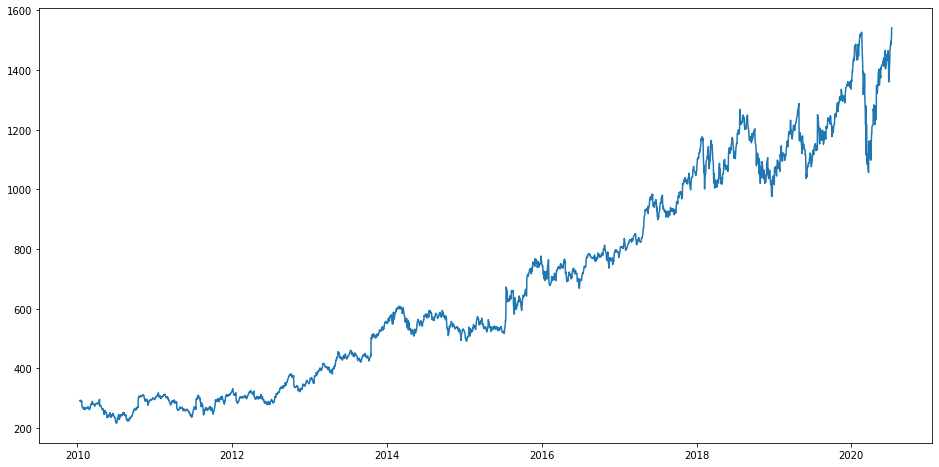

In [6]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

# Selecting of Required Data

In [7]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
new_data.head()

,Date,Close
0,2010-01-13 00:00:00,292.449
1,2010-01-14 00:00:00,293.824
2,2010-01-15 00:00:00,288.917
3,2010-01-19 00:00:00,292.713
4,2010-01-20 00:00:00,289.121


In [8]:
new_data.tail()

,Date,Close
2636,2020-07-06 00:00:00,1495.7
2637,2020-07-07 00:00:00,1485.18
2638,2020-07-08 00:00:00,1496
2639,2020-07-09 00:00:00,1510.99
2640,2020-07-10 00:00:00,1541.74


In [9]:
len(new_data)

2641

# Spliting the Training Data 

In [10]:
#creating dataframe
train_data = pd.DataFrame(index=range(0,2000),columns=['Date', 'Close'])
for i in range(0,2000):
    train_data['Date'][i] = new_data['Date'][i]
    train_data['Close'][i] = new_data['Close'][i]
train_data.tail()


,Date,Close
1995,2017-12-14 00:00:00,1049.15
1996,2017-12-15 00:00:00,1064.19
1997,2017-12-18 00:00:00,1077.14
1998,2017-12-19 00:00:00,1070.68
1999,2017-12-20 00:00:00,1064.95


# Spliting the Test Data

In [13]:
#creating dataframe
len_test = len(new_data[2000::])
test_data = pd.DataFrame(index=range(0,len_test),columns=['Date', 'Close'])
for i in range(0,len_test):
    test_data['Date'][i] = new_data['Date'][i+2000]
    test_data['Close'][i] = new_data['Close'][i+2000]
test_data.tail()

,Date,Close
636,2020-07-06 00:00:00,1495.7
637,2020-07-07 00:00:00,1485.18
638,2020-07-08 00:00:00,1496
639,2020-07-09 00:00:00,1510.99
640,2020-07-10 00:00:00,1541.74


In [14]:
start_dataset = pd.Timestamp("2010-01-13 00:00:00")
end_training = pd.Timestamp("2017-12-20 00:00:00")
end_testing = pd.Timestamp("2020-07-10 00:00:00")

In [15]:
training_data = [
    {
        "start": str(start_dataset),
        "target": train_data['Close'].tolist()
    }
]

In [16]:
#print((training_data))

In [17]:
#train_data['Date']

In [18]:
testing_data = [
    {
        "start": str(end_training),
        "target": test_data['Close'].tolist()
    }
]

In [19]:
#print((testing_data))

# Preperation of Training and Testing Data Files

In [20]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [21]:
write_dicts_to_file("/content/drive/My Drive/AICamp/DL/TimeSeries/Data/stock_train.json", training_data)
write_dicts_to_file("/content/drive/My Drive/AICamp/DL/TimeSeries/Data/stock_test.json", testing_data)

# Hyperparameters
![alt text](https://drive.google.com/uc?export=view&id=1AS66Y0h-glRx_jMu-z_xKpBljgxtJmKE)


# Metrics
![alt text](https://drive.google.com/uc?export=view&id=1-aVCT8k5UBzObKdT5QKRVS1oKN6Y4KnX)

# Lambda
![alt text](https://drive.google.com/uc?export=view&id=1ZTvMG6K8OtZpaDWIeblsA7gN3aTp5gjt)

# Postman
![alt text](https://drive.google.com/uc?export=view&id=1sJHWAk2ZkCqKmQov0qof6eP4t6aZPXKF)

# Result Verification
### (test resuls are taken from different programme)


In [28]:
import requests
import json
def get_prediction(data):
    url = 'https://mng9vecu3b.execute-api.us-east-1.amazonaws.com/AICamp-Timeseries-3A/aicamp-timeseries-3a'
    r = requests.post(url, data=json.dumps(data))
    response = getattr(r,'_content').decode("utf-8")
    #print(response)
    return response

In [ ]:
predictions = []
for a in range(0,10):
    test_sample = {}
    test_sample = {"instances": [testing_data.copy()]}
    test_sample["instances"]["target"] = testing_data["target"][a:a+100]
    test_sample["configuration"] =  {"output_types": ["mean",
                                                      "quantiles"
                                                     ],
                                     "quantiles": ["0.1",
                                                   "0.9"
                                                  ]
                                    }
    prediction_sample = json.loads(get_prediction(test_sample))['body']['predictions']['quantiles']['0.9']
    predictions.append(prediction_sample)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(predictions[9], label="predictions")
plt.plot(test_data[house]["target"][109:129], label="true value")
#plt.xlabel('freq = 2H')
plt.xlabel('freq = D')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


## The following graph shows that 90% of the generated values are below the value

![alt text](https://drive.google.com/uc?export=view&id=17zrbzGeCnyWqimN44uG8amoFcvyxQVlQ)